- incorporate lecture ratio info

In [1]:
import sys
import copy
import random
import feather
import warnings
import numpy as np
import pandas as pd
from time import time
import lightgbm as lgb
from collections import Counter
from sklearn import preprocessing
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt 
from tqdm._tqdm_notebook import tqdm_notebook

import riiideducation
warnings.filterwarnings("ignore")
tqdm_notebook.pandas(desc="progress: ")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`


In [2]:
DIR = "../input/riiid-test-answer-prediction/"
train = pd.read_feather("../input/riid-train/train.feather")
lectures = pd.read_csv(DIR+"lectures.csv")
questions = pd.read_csv(DIR+"questions.csv")

In [3]:
lecture_id = list(lectures.lecture_id.unique())

# preprocess

In [4]:
# executed in advance
train = train.sort_values(['user_id', 'timestamp']).reset_index(drop=True)
train.drop(["row_id", "user_answer", "timestamp"], axis=1, inplace=True)

In [5]:
print("consider lecture data")
user_lec_df = train.groupby('user_id').agg({'content_type_id': ['mean']}).copy()
user_lec_df.columns = ["lec_ratio"]

train["lec"] = train.groupby(["user_id"])['content_type_id'].progress_apply(lambda x: x.shift(1))
train.drop(["content_type_id"], axis=1, inplace=True)
train["lec"] = train["lec"].fillna(0)

print("remove lecture data")
train = train.loc[train['answered_correctly'] != -1].reset_index(drop=True)

print("merge question data")
# https://stackoverflow.com/questions/25888207/pandas-join-dataframes-on-field-with-different-names
train = train.merge(questions[["question_id", "part"]], how="left", left_on=['content_id'], right_on=['question_id'])
train.drop(["question_id"], axis=1, inplace=True)

print("groupby calculation")
user_answers_df = train.groupby('user_id').agg({'answered_correctly': ['mean']}).copy()
user_answers_df.columns = ["acc_before_ans"]

user_answers_past2 = pd.DataFrame(train.groupby("user_id").tail(2).groupby("user_id").agg("mean")["answered_correctly"])
user_answers_past2.columns = ["mean_of_last_2_answered_correctly_by_user_id"]
user_answers_past3 = pd.DataFrame(train.groupby("user_id").tail(3).groupby("user_id").agg("mean")["answered_correctly"])
user_answers_past3.columns = ["mean_of_last_3_answered_correctly_by_user_id"]

user_part_accuracy = train.groupby(['user_id', 'part']).agg({'answered_correctly': ['mean']}).copy().unstack()
user_part_accuracy.columns = ["part1_acc", "part2_acc", "part3_acc", "part4_acc", "part5_acc", "part6_acc", "part7_acc"]

user_lec_ratio = train.groupby(['user_id']).agg({'lec': ['mean']}).copy()
user_lec_ratio.columns = ["lec"]

mean_accuracy_by_part = np.array([0.74503238, 0.70869406, 0.70145593, 0.63099758, 0.61008792, 0.66938835, 0.65960112])

consider lecture data



remove lecture data
merge question data
groupby calculation


In [6]:
# to get first index of a particular user
for i in train.groupby("user_id").first().index:
    if i > 85000000:
        print(i)
        break

85001706


In [7]:
train = train.iloc[90007298:,:]
train['task_container_id'] = train.groupby('user_id')['task_container_id'].transform(lambda x: pd.factorize(x)[0]).astype('int16')
print(train.shape, len(train.user_id.unique()))
train.head(10)

(9264002, 8) 36706


,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,lec,part
90007298,1947975793,6603,0,1,20500,True,0.0,6
90007299,1947975793,6601,0,1,20500,True,0.0,6
90007300,1947975793,6602,0,1,20500,True,0.0,6
90007301,1947975793,10076,1,1,6000,True,0.0,6
90007302,1947975793,10077,1,0,6000,True,0.0,6
90007303,1947975793,10075,1,0,6000,True,0.0,6
90007304,1947975793,10074,1,0,6000,True,0.0,6
90007305,1947975793,10075,2,0,22750,True,1.0,6
90007306,1947975793,10076,2,1,22750,True,0.0,6
90007307,1947975793,10074,2,0,22750,True,0.0,6


# Feature engineering

In [8]:
%%time
def get_data(df, test_set=False):
    if test_set == False:
        
        # cumsum correct answer by user_id
        tmp1 = df.groupby(['user_id'])['answered_correctly'].apply(lambda x: pd.concat([pd.DataFrame([0]), x.cumsum()[:-1]])).reset_index(drop=True).values
        tmp1 = np.array(tmp1, dtype=float)
        # cumsum total try by user_id
        tmp2 = df.groupby(['user_id']).cumcount().values
        tmp2 = np.array(tmp2, dtype=float).reshape(-1,1)
        # https://stackoverflow.com/questions/26248654/how-to-return-0-with-divide-by-zero
        correct_rate = np.divide(tmp1, tmp2, out=np.ones_like(tmp1)*-1, where=tmp2!=0)
        
        # cumsum lec count by user_id 
        tmp1 = df.groupby(['user_id'])['lec'].apply(lambda x: x.cumsum()).reset_index(drop=True).values
        tmp1 = np.array(tmp1, dtype=float).reshape(-1,1)
        lec_rate = np.divide(tmp1, tmp2, out=np.zeros_like(tmp1), where=tmp2!=0)
        
        # cumsum of each part trial by user
        part1_cumsum = df.groupby(["user_id"])['part'].apply(lambda x: pd.DataFrame([0] + (x==1).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part2_cumsum = df.groupby(["user_id"])['part'].apply(lambda x: pd.DataFrame([0] + (x==2).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part3_cumsum = df.groupby(["user_id"])['part'].apply(lambda x: pd.DataFrame([0] + (x==3).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part4_cumsum = df.groupby(["user_id"])['part'].apply(lambda x: pd.DataFrame([0] + (x==4).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part5_cumsum = df.groupby(["user_id"])['part'].apply(lambda x: pd.DataFrame([0] + (x==5).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part6_cumsum = df.groupby(["user_id"])['part'].apply(lambda x: pd.DataFrame([0] + (x==6).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part7_cumsum = df.groupby(["user_id"])['part'].apply(lambda x: pd.DataFrame([0] + (x==7).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values

        # logical bool if part is matched by user
        part1_g = pd.DataFrame(df.groupby(["user_id"])['part'].apply(lambda x: x==1))
        part2_g = pd.DataFrame(df.groupby(["user_id"])['part'].apply(lambda x: x==2))
        part3_g = pd.DataFrame(df.groupby(["user_id"])['part'].apply(lambda x: x==3))
        part4_g = pd.DataFrame(df.groupby(["user_id"])['part'].apply(lambda x: x==4))
        part5_g = pd.DataFrame(df.groupby(["user_id"])['part'].apply(lambda x: x==5))
        part6_g = pd.DataFrame(df.groupby(["user_id"])['part'].apply(lambda x: x==6))
        part7_g = pd.DataFrame(df.groupby(["user_id"])['part'].apply(lambda x: x==7))
        # logical bool if answer is correct by user
        acc_g = pd.DataFrame(df.groupby(["user_id"])['answered_correctly'].apply(lambda x: x==1))

        # cumsum of correct num per part by user
        part1_acc_cumsum = np.logical_and(acc_g.values ,part1_g.values)
        part2_acc_cumsum = np.logical_and(acc_g.values ,part2_g.values)
        part3_acc_cumsum = np.logical_and(acc_g.values ,part3_g.values)
        part4_acc_cumsum = np.logical_and(acc_g.values ,part4_g.values)
        part5_acc_cumsum = np.logical_and(acc_g.values ,part5_g.values)
        part6_acc_cumsum = np.logical_and(acc_g.values ,part6_g.values)
        part7_acc_cumsum = np.logical_and(acc_g.values ,part7_g.values)

        df["part1_and_ok"] = part1_acc_cumsum
        df["part2_and_ok"] = part2_acc_cumsum
        df["part3_and_ok"] = part3_acc_cumsum
        df["part4_and_ok"] = part4_acc_cumsum 
        df["part5_and_ok"] = part5_acc_cumsum
        df["part6_and_ok"] = part6_acc_cumsum
        df["part7_and_ok"] = part7_acc_cumsum
        
        part1_acc_cumsum = df.groupby(["user_id"])['part1_and_ok'].apply(lambda x: pd.DataFrame([0] + (x==1).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part2_acc_cumsum = df.groupby(["user_id"])['part2_and_ok'].apply(lambda x: pd.DataFrame([0] + (x==1).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part3_acc_cumsum = df.groupby(["user_id"])['part3_and_ok'].apply(lambda x: pd.DataFrame([0] + (x==1).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part4_acc_cumsum = df.groupby(["user_id"])['part4_and_ok'].apply(lambda x: pd.DataFrame([0] + (x==1).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part5_acc_cumsum = df.groupby(["user_id"])['part5_and_ok'].apply(lambda x: pd.DataFrame([0] + (x==1).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part6_acc_cumsum = df.groupby(["user_id"])['part6_and_ok'].apply(lambda x: pd.DataFrame([0] + (x==1).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part7_acc_cumsum = df.groupby(["user_id"])['part7_and_ok'].apply(lambda x: pd.DataFrame([0] + (x==1).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values

        part1_acc_cumsum = np.array(part1_acc_cumsum, dtype=float)
        part2_acc_cumsum = np.array(part2_acc_cumsum, dtype=float)
        part3_acc_cumsum = np.array(part3_acc_cumsum, dtype=float)
        part4_acc_cumsum = np.array(part4_acc_cumsum, dtype=float)
        part5_acc_cumsum = np.array(part5_acc_cumsum, dtype=float)
        part6_acc_cumsum = np.array(part6_acc_cumsum, dtype=float)
        part7_acc_cumsum = np.array(part7_acc_cumsum, dtype=float)
        
        part1_acc_rate = np.divide(part1_acc_cumsum, part1_cumsum, out=np.ones_like(part1_acc_cumsum)*-1, where=part1_cumsum!=0)
        part2_acc_rate = np.divide(part2_acc_cumsum, part2_cumsum, out=np.ones_like(part2_acc_cumsum)*-1, where=part2_cumsum!=0)
        part3_acc_rate = np.divide(part3_acc_cumsum, part3_cumsum, out=np.ones_like(part3_acc_cumsum)*-1, where=part3_cumsum!=0)
        part4_acc_rate = np.divide(part4_acc_cumsum, part4_cumsum, out=np.ones_like(part4_acc_cumsum)*-1, where=part4_cumsum!=0)
        part5_acc_rate = np.divide(part5_acc_cumsum, part5_cumsum, out=np.ones_like(part5_acc_cumsum)*-1, where=part5_cumsum!=0)
        part6_acc_rate = np.divide(part6_acc_cumsum, part6_cumsum, out=np.ones_like(part6_acc_cumsum)*-1, where=part6_cumsum!=0)
        part7_acc_rate = np.divide(part7_acc_cumsum, part7_cumsum, out=np.ones_like(part7_acc_cumsum)*-1, where=part7_cumsum!=0)
                    
        df["acc_before_ans"] = correct_rate
        df["part1_acc"] = part1_acc_rate
        df["part2_acc"] = part2_acc_rate
        df["part3_acc"] = part3_acc_rate
        df["part4_acc"] = part4_acc_rate
        df["part5_acc"] = part5_acc_rate
        df["part6_acc"] = part6_acc_rate
        df["part7_acc"] = part7_acc_rate  
        df['prior_question_had_explanation'] = df['prior_question_had_explanation'].fillna(value = False).astype(bool)
        df["lec"] = lec_rate
        
    else:
        df = df.merge(user_answers_df, how = 'left', on = 'user_id') # for acc_before_ans
        df = df.merge(user_part_accuracy, how = 'left', on = 'user_id')
        df = df.merge(user_answers_past2, how = 'left', on = 'user_id')
        df = df.merge(user_answers_past3, how = 'left', on = 'user_id')
        df = df.merge(user_lec_ratio, how = 'left', on = 'user_id')
        df.drop(["timestamp"], axis=1, inplace=True)
    
    df.fillna(value = 0.5, inplace = True) #0?
    return df
train = get_data(train)

CPU times: user 13min 11s, sys: 12.1 s, total: 13min 24s
Wall time: 13min 19s


In [9]:
# target encoding + moving average not to cause target leakage
AGGS = [
    ('answered_correctly', 2, ['user_id'], ['mean']),
    ('answered_correctly', 3, ['user_id'], ['mean']),
]

for on, lag, by, hows in AGGS:
    agg = train.groupby(by)[on].apply(lambda x: (
        x.shift(1).rolling(window=lag, min_periods=1).agg(hows)
    ))
    agg = agg.rename(columns={
        how: f'{how}_of_last_{lag}_{on}_by_' + '_and_'.join(by)
        for how in hows
    })

    train = train.join(agg)

In [10]:
target = 'answered_correctly'
columns = ["acc_before_ans", 'content_id', 'part', 'prior_question_had_explanation', 'prior_question_elapsed_time',
          "part1_acc",  "part2_acc", "part3_acc", "part4_acc", "part5_acc", "part6_acc", "part7_acc",
           "mean_of_last_2_answered_correctly_by_user_id", "mean_of_last_3_answered_correctly_by_user_id", "lec"]
others = ['task_container_id', "user_id"]

drop_columns = [i for i in train.columns if i not in columns + [target] + others]
train.drop(drop_columns, axis=1, inplace=True)

In [11]:
train

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,lec,part,acc_before_ans,part1_acc,part2_acc,part3_acc,part4_acc,part5_acc,part6_acc,part7_acc,mean_of_last_2_answered_correctly_by_user_id,mean_of_last_3_answered_correctly_by_user_id
90007298,1947975793,6603,0,1,20500,True,0.0,6,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,NaN,NaN
90007299,1947975793,6601,0,1,20500,True,0.0,6,1.000000,-1.0,-1.0,-1.0,-1.0,-1.000000,1.0,-1.0,1.0,1.000000
90007300,1947975793,6602,0,1,20500,True,0.0,6,1.000000,-1.0,-1.0,-1.0,-1.0,-1.000000,1.0,-1.0,1.0,1.000000
90007301,1947975793,10076,1,1,6000,True,0.0,6,1.000000,-1.0,-1.0,-1.0,-1.0,-1.000000,1.0,-1.0,1.0,1.000000
90007302,1947975793,10077,1,0,6000,True,0.0,6,1.000000,-1.0,-1.0,-1.0,-1.0,-1.000000,1.0,-1.0,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99271295,2147482888,3586,22,1,18000,True,0.0,5,0.500000,1.0,-1.0,-1.0,-1.0,0.476190,-1.0,-1.0,1.0,1.000000
99271296,2147482888,6341,23,1,14000,True,0.0,5,0.521739,1.0,-1.0,-1.0,-1.0,0.500000,-1.0,-1.0,1.0,1.000000
99271297,2147482888,4212,24,1,14000,True,0.0,5,0.541667,1.0,-1.0,-1.0,-1.0,0.521739,-1.0,-1.0,1.0,1.000000
99271298,2147482888,6343,25,0,22000,True,0.0,5,0.560000,1.0,-1.0,-1.0,-1.0,0.541667,-1.0,-1.0,1.0,1.000000


# modelling

In [12]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices
        
    @property
    def before_iteration(self):
        # コールバックは各イテレーションの後に実行する
        return False

In [13]:
categoricals = ["content_id", "part"]
params = {'objective': 'binary', "metric": 'auc','eval_metric':'auc', 'boosting_type': 'gbdt', 'tree_learner': 'serial', 'learning_rate': 0.1, 
               "num_leaves": 30, 'random_seed':44, 'max_depth': 8} 
n_folds=5

def modelling_lgb(X_train, y_train):
    groups = np.array(X_train.user_id.values)
    
    models = []

    valid = np.array([])
    real = np.array([])
    features_list = [i for i in columns]
    feature_importance_df = pd.DataFrame(features_list, columns=["Feature"])
        
    for i , (train_index, test_index) in enumerate(stratified_group_k_fold(X_train, y_train, groups, k=n_folds, seed=0)):
        print("Fold {}".format(i+1))
        X_train2 = X_train.iloc[train_index,:]
        y_train2 = y_train.iloc[train_index]

        X_valid2 = X_train.iloc[test_index,:]
        
        # https://stackoverflow.com/questions/15705630/get-the-rows-which-have-the-max-count-in-groups-using-groupby
        max_idx = X_valid2.groupby(['user_id'])['task_container_id'].transform(max) == X_valid2['task_container_id']
        min_idx = X_valid2.groupby(['user_id'])['task_container_id'].transform(min) == X_valid2['task_container_id']
        X_valid2 = X_valid2[max_idx|min_idx]
        
        y_valid2 = y_train.iloc[test_index]
        y_valid2 = y_valid2[max_idx|min_idx]
        X_train2.drop(others, axis=1, inplace=True)
        X_valid2.drop(others, axis=1, inplace=True)

        lgb_train = lgb.Dataset(X_train2, y_train2)
        lgb_eval = lgb.Dataset(X_valid2, y_valid2, reference=lgb_train)
        
        clf = lgb.train(params, lgb_train,valid_sets=[lgb_train, lgb_eval], 
               num_boost_round=550,early_stopping_rounds=10,verbose_eval = 50, categorical_feature=categoricals,)
        feature_importance_df["Fold_"+str(i+1)] = clf.feature_importance()

        valid_predict = clf.predict(X_valid2, num_iteration = clf.best_iteration)
        
        valid = np.concatenate([valid, valid_predict])
        real = np.concatenate([real, y_valid2])
        
        models.append(clf) 
        
    feature_importance_df["Average"] = np.mean(feature_importance_df.iloc[:,1:n_folds+1], axis=1)
    feature_importance_df["Std"] = np.std(feature_importance_df.iloc[:,1:n_folds+1], axis=1)
    feature_importance_df["Cv"] = feature_importance_df["Std"] / feature_importance_df["Average"]
    feature_importance_df = feature_importance_df.sort_values("Average", ascending=False).reset_index(drop=True)
        
    score = roc_auc_score(real, valid)
    print("Overall ROC AUC: ", score)
            
    return models, feature_importance_df
models, feature_importance_df = modelling_lgb(train[columns + others], train[target])

Fold 1
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.712563	valid_1's auc: 0.723317
[100]	training's auc: 0.729427	valid_1's auc: 0.737151
[150]	training's auc: 0.738478	valid_1's auc: 0.744865
[200]	training's auc: 0.743771	valid_1's auc: 0.748558
[250]	training's auc: 0.74852	valid_1's auc: 0.752136
[300]	training's auc: 0.751659	valid_1's auc: 0.755159
[350]	training's auc: 0.75351	valid_1's auc: 0.756381
[400]	training's auc: 0.755389	valid_1's auc: 0.757746
[450]	training's auc: 0.75688	valid_1's auc: 0.758904
[500]	training's auc: 0.758085	valid_1's auc: 0.759968
Early stopping, best iteration is:
[524]	training's auc: 0.758731	valid_1's auc: 0.760188
Fold 2
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.713485	valid_1's auc: 0.725499
[100]	training's auc: 0.73002	valid_1's auc: 0.739115
[150]	training's auc: 0.738419	valid_1's auc: 0.744841
[200]	training's auc: 0.744757	valid_1's auc: 0.749845
[250]	trai

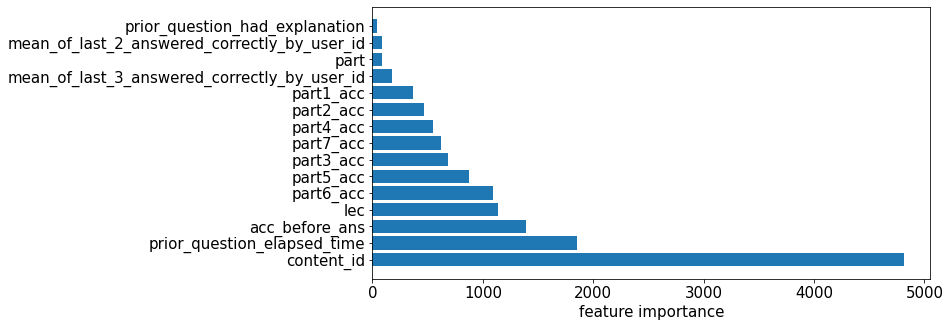

In [14]:
plt.rcParams.update({'font.size': 15})
x = list(feature_importance_df["Feature"].values)
y = feature_importance_df["Average"].values

x_position = np.arange(len(x))

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1)
ax.barh(x_position, y, tick_label=x)
ax.set_xlabel('feature importance')
plt.show()

# prediction

In [15]:
del train

In [16]:
env = riiideducation.make_env()
iter_test = env.iter_test()

for (test_df, sample_prediction_df) in iter_test:
    y_preds = []
    test_df = test_df.merge(questions[["question_id", "part"]], how="left", left_on=['content_id'], right_on=['question_id'])
    test_df.drop(["question_id"], axis=1, inplace=True)

    test_df['prior_question_had_explanation'] = test_df['prior_question_had_explanation'].fillna(value = False).astype(bool)
    test_df = get_data(test_df, test_set=True)

    for model in models:
        y_pred = model.predict(test_df[columns], num_iteration=model.best_iteration)
        y_preds.append(y_pred)

    y_preds = sum(y_preds) / len(y_preds)
    test_df['answered_correctly'] = y_preds
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])